# Motivation

The CityLearn Challenge 2022 was offered as a NeurIPS competition to "minimise the monetary cost of electricity drawn from the grid and the CO2 emissions when electicity demand is satsified by the grid".

Buildings are responsible for 30% of greenhouse gas emissions, and the use of residential rooftop solar panels is being promoted as a popular way to bring this figure down. This brings with it additional technical challenges: at peak times, the electricity generated may be more than the household's demand (load), while at other times such as at night the solar panel will not be able to meet the demand. Excess electricity can be stored in batteries, but there is an inefficiency associated with both charging and discharging it; at times, it may be more cost- and resource-efficient to rely on the grid and not the battery. This is an unsolved problem at the moment, resulting in higher financial and carbon costs than necessary. The aim of this challenge is to develop a reinforcement learning policy and reward function that while efforts to install more rooftop solar panels are mitigating this, for best performance efficiencies need to be made during the charge and discharge of batteries.

The solution is evaluated by testing it on one year of data for a collection of buildings, and giving it a score composed of the cost relative to if there were no battery, added to the CO2 emissions relative to if there were no battery.

**Observations**
* "Calendar" category: month, day of the week, hour of the day
* "Weather" category: current and predicted future temperature, humidity, diffuse solar irradiance, and direct solar irradiance
* "District" category: rate of carbon emissions of the grid
* "Building" category: temperature and humidity of the building, non-shiftable loads, electricity generated by solar panels, current storage capacity, electricity consumption, current and future electricity grid price, etc.

**Actions**

There are 6 actions, each one taking a continuous value from -1 to 1 representing the proportion of a storage device that should be (dis)charged.

**Baselines**

The CityLearn package provides a random policy and a rule-based policy to be used as baselines. We also have the winning solution against which to compare.

Here we will develop 2 additional baselines against which to compare an optimised reinforcement learning model:
* An agent that takes the same action regardless of inputs
* A gradient-boosted tree model trained on random rules

## Exploring

In [1]:
%%capture
!pip install CityLearn==1.8.0

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet

In [4]:
# Initialise CityLearn environment
DATASET_NAME = 'citylearn_challenge_2022_phase_1'
schema = DataSet.get_schema(DATASET_NAME)
env = CityLearnEnv(schema)

In [5]:
from citylearn.base import Environment

Action space to sample from

In [6]:
env = CityLearnEnv(schema, central_agent=True)
env.action_space

[Box(-0.78125, 0.78125, (5,), float32)]

The action space is a continuous space, with a vector of 5 actions (one for each building) which can take values between -0.78125 and 0.78125.

Observation space

In [8]:
obs_names = env.observation_names
print(f"The observations contain {len(obs_names)} sublist(s) of observations")
set(obs_names[0])

The observations contain 1 sublist(s) of observations


{'carbon_intensity',
 'day_type',
 'diffuse_solar_irradiance',
 'diffuse_solar_irradiance_predicted_12h',
 'diffuse_solar_irradiance_predicted_24h',
 'diffuse_solar_irradiance_predicted_6h',
 'direct_solar_irradiance',
 'direct_solar_irradiance_predicted_12h',
 'direct_solar_irradiance_predicted_24h',
 'direct_solar_irradiance_predicted_6h',
 'electrical_storage_soc',
 'electricity_pricing',
 'electricity_pricing_predicted_12h',
 'electricity_pricing_predicted_24h',
 'electricity_pricing_predicted_6h',
 'hour',
 'month',
 'net_electricity_consumption',
 'non_shiftable_load',
 'outdoor_dry_bulb_temperature',
 'outdoor_dry_bulb_temperature_predicted_12h',
 'outdoor_dry_bulb_temperature_predicted_24h',
 'outdoor_dry_bulb_temperature_predicted_6h',
 'outdoor_relative_humidity',
 'outdoor_relative_humidity_predicted_12h',
 'outdoor_relative_humidity_predicted_24h',
 'outdoor_relative_humidity_predicted_6h',
 'solar_generation'}

Just exploring: what happens if we take action 0 for all buildings over a period of 3 monthds?

In [9]:
# Details of the environment: the dataset contains 5 buildings, and timesteps are per hour over the desired 3 months
n_buildings = 5
n_timesteps = 3 * 30 * 24

# Reset environment
env = CityLearnEnv(schema, central_agent=True, simulation_end_time_step=n_timesteps)
observation = env.reset()

# Initialise variables to store observations and rewards
obs = [observation]
rewards = [0]

# Iterate over n_timesteps timesteps, taking action 0 each time
done = False
while not done:
  next_obs, r, done, info = env.step(np.zeros((n_buildings, 0)))
  obs.append(next_obs)
  rewards.append(r[0])


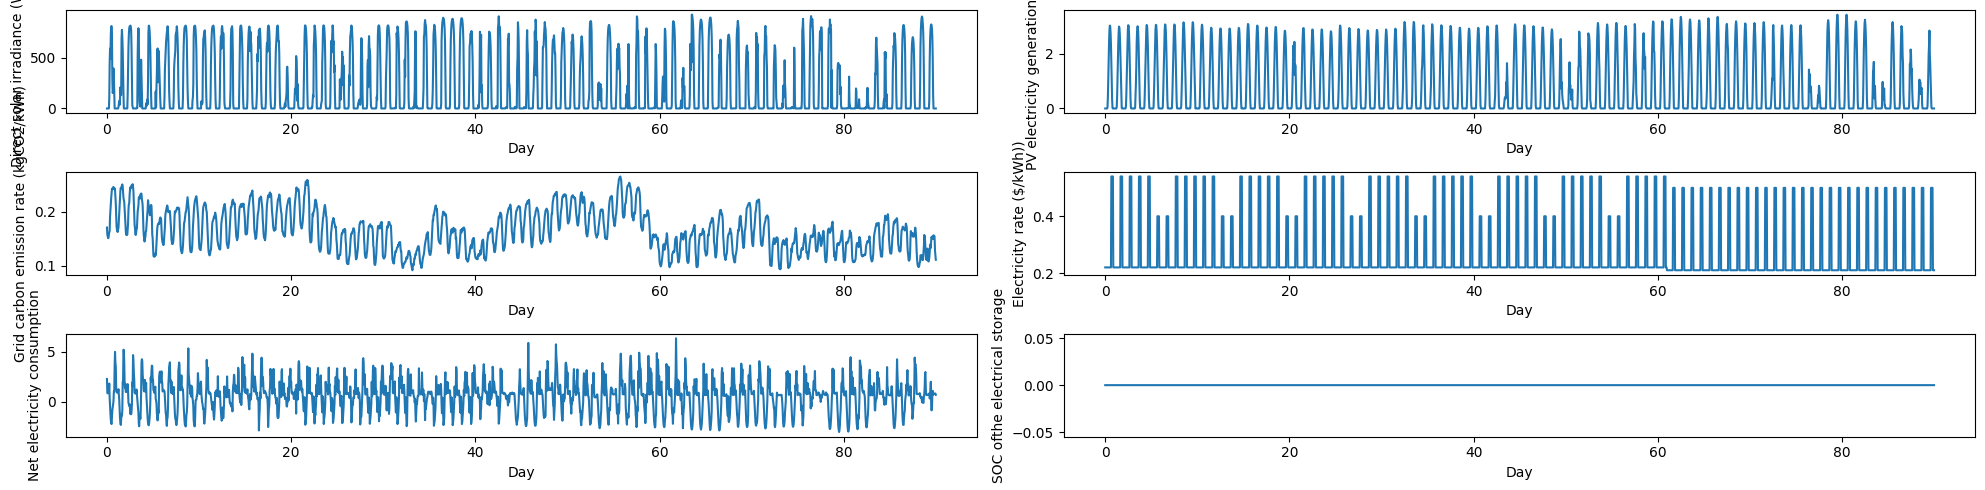

In [10]:
# Plot some of the observation values

fig, ax = plt.subplots(3, 2, figsize=(20, 5))
timestamps = np.arange(0, (n_timesteps+0.95)/24, 1/24)

# Plot direct solar irradiance (this has a strong influence on electricity generation)
i = np.where([x=="direct_solar_irradiance" for x in obs_names[0]])[0][0]
ax[0][0].plot(timestamps, [x[0][i] for x in obs])
ax[0][0].set_xlabel("Day")
ax[0][0].set_ylabel("Direct solar irradiance (W/m2)")

# Plot electricity generation from solar panels (when this is greater, it may be beneficial to charge the battery more)
i = np.where([x=="solar_generation" for x in obs_names[0]])[0][0]
ax[0][1].plot(timestamps, [x[0][i] for x in obs])
ax[0][1].set_xlabel("Day")
ax[0][1].set_ylabel("PV electricity generation (kWh)")

# Plot carbon intensity of the grid (when this is higher, it may be beneficial to discharge the battery more)
i = np.where([x=="carbon_intensity" for x in obs_names[0]])[0][0]
ax[1][0].plot(timestamps, [x[0][i] for x in obs])
ax[1][0].set_xlabel("Day")
ax[1][0].set_ylabel("Grid carbon emission rate (kgCO2/kWh)")

# Plot grid electricity price (when this is higher, it may be beneficial to discharge the battery more)
i = np.where([x=="electricity_pricing" for x in obs_names[0]])[0][0]
ax[1][1].plot(timestamps, [x[0][i] for x in obs])
ax[1][1].set_xlabel("Day")
ax[1][1].set_ylabel("Electricity rate ($/kWh))")

# Plot electricity consumption (when this is higher, the actions have a stronger influence on reward)
i = np.where([x=="net_electricity_consumption" for x in obs_names[0]])[0][0]
ax[2][0].plot(timestamps, [x[0][i] for x in obs])
ax[2][0].set_xlabel("Day")
ax[2][0].set_ylabel("Net electricity consumption")

# Plot state of battery charge (this should be constantly 0 for this agent)
i = np.where([x=="electrical_storage_soc" for x in obs_names[0]])[0][0]
ax[2][1].plot(timestamps, [x[0][i] for x in obs])
ax[2][1].set_xlabel("Day")
ax[2][1].set_ylabel("SOC ofthe electrical storage")

plt.tight_layout()
plt.show()

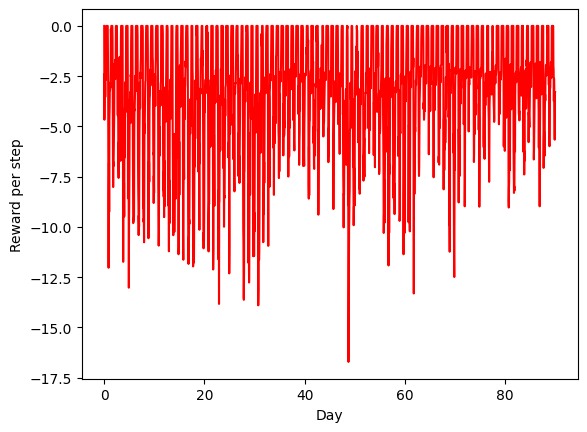

In [11]:
# Plot the reward
plt.plot(timestamps, rewards, 'r')
plt.xlabel("Day")
plt.ylabel("Reward per step")
plt.show()

Now, we use CityLearn's inbuilt random agent

In [12]:
from citylearn.agents.rbc import HourRBC

# Reset environment
observation = env.reset()

# Initialise random agent
random_agent = HourRBC(env=env)

# Initialise variables to store observations and rewards
obs = [observation]
random_rewards = [0]

# Iterate over n_timesteps timesteps, taking a random action each time
done = False
while not done:
  actions = random_agent.predict(observation, deterministic=True)
  observation, r, done, info = env.step(actions)
  random_rewards.append(r[0])

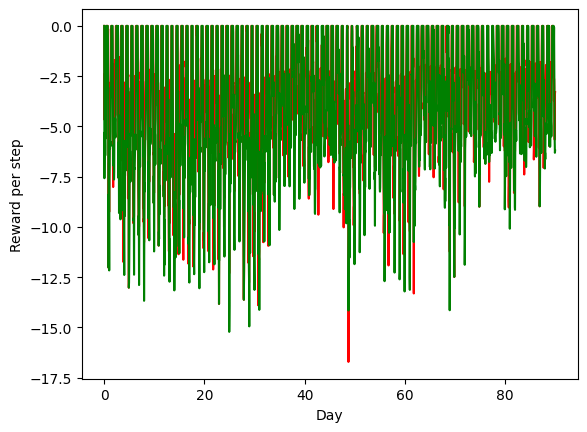

In [13]:
# Plot the reward
plt.plot(timestamps, rewards, 'r')
plt.plot(timestamps, random_rewards, 'g')
plt.xlabel("Day")
plt.ylabel("Reward per step")
plt.show()

In [16]:
# Evaluate the agent
kpis = random_agent.env.evaluate()
kpis.head(15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cost_function,value,name,level
0,1 - load_factor,0.982408,District,district
1,average_daily_peak,1.125109,District,district
2,carbon_emissions,1.191711,District,district
3,cost,1.106572,District,district
4,electricity_consumption,1.269455,District,district


In [21]:
# Create a function to get a score
def get_score(agent):

  # Evaluate agent
  kpis = random_agent.env.evaluate()

  # Calculate score from relevant KPIs
  Centry = kpis["value"].loc[(kpis["cost_function"]=="cost") & (kpis["name"]=="District")]
  Gentry = kpis["value"].loc[(kpis["cost_function"]=="carbon_emissions") & (kpis["name"]=="District")]
  score = Centry + Gentry

  return score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    1.106572
Name: value, dtype: float64

In [50]:
# Print results
constant_agent_cumulative_reward = sum(rewards)
random_agent_reward_cumulative_reward = sum(random_rewards)
print(f"Cumulative reward over 3 months with constant action 0 is {constant_agent_cumulative_reward:.2f}")
print(f"Cumulative reward over 3 months with random actions is {random_agent_reward_cumulative_reward:.2f}")

Cumulative reward over 3 months with constant action 0 is -23650.47
Cumulative reward over 3 months with random actions is -29996.18


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
sum(([x[0] for x in rewards[1:]]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-23650.465247873406

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


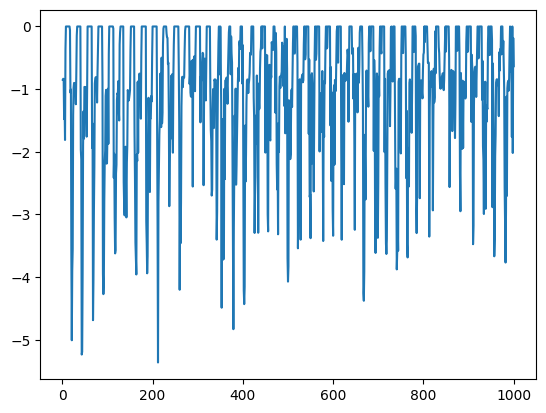

In [65]:
import matplotlib.pyplot as plt
plt.plot([x[0] for x in rewards])

In [7]:
from citylearn.agents.rbc import HourRBC

# Action map: take action 0 at every timestep
action_map = {i: 0.0 for i in range(1, 25)}

# Train rule-based control agent
model = HourRBC(env=env, action_map=action_map)
model.learn(episodes=1)

# Plot non-shiftable load
plt.plot(np.arange(0, 365, 1/24), env.buildings[0].energy_simulation.non_shiftable_load)

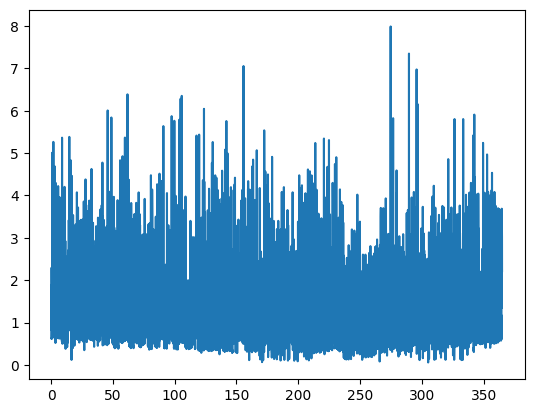

In [19]:
8760/24

365.0

In [16]:
24*60*6

8640